# Getting Started

Here we go through a simplified motor simulation to get you started. Let's start by importing the solidpy module.

In [2]:
import sys
sys.path.append('../')
import numpy as np
from solidpy import Bates, Star, CustomGeometry
from solidpy import Motor, Propellant, Environment, Rail
from solidpy import BurnSimulation, Export

If you are using Jupyter Notebooks, it is recommended to run the following line to make matplotlib plots which will be shown later interactive and higher quality.

In [3]:
%matplotlib inline

## Setting Up a Simulation

### Creating your rocket propellant

Here we need to define some of the properties of our chosen propellant.
Among them is the specific heat ratio ($\gamma$), propellant density ($\rho$), molecular mass of the products of combustion ($M$) and adiabatic flame temperature ($T$). These can be easily obtained for any given composition from a thermochemical equilibrium solver such as [PROPEP](http://rocketworkbench.sourceforge.net/equil.phtml).

We'll also need some parameters regarding how the propellant burn rate behaves. Solid propellant burn rates are commonly modelled solely as a function of the local static chamber pressure, following semi-empirical relation known as Saint-Robert's law or Vielle's Law:

$r = a{P_0}^n$

Where $P_0$ represents the chamber stagnation pressure. The $a$ and $n$ are respectively called the *linear* and *exponential* ballistic coefficients and should be obtained empirically for your given propellant formulation and manufacturing process. Note that a value of *n < 1* is required for a stable burn.

Here we'll create an instance of the KNSB (65% KNO3, 35% sorbitol) propellant, widely used by Projeto Jupiter's propulsion team. Burn rate coefficients have been sourced from [Richard Nakka's Experimental Rocketry Site](https://www.nakka-rocketry.net).

In [4]:
KNSB = Propellant(
    specific_heat_ratio=1.1361,
    density=1700,
    products_molecular_mass=39.9e-3,
    combustion_temperature=1600,
    burn_rate_a=5.8,
    burn_rate_n=0.22
)

Alternatively, SolidPy allows you to input a customized *Burnrate (mm/s) x Pressure (MPa)* curve by passing on a CSV file that will be interpolated. This allows for more flexibility regarding propellant behaviour, and for many formulations there is raised data from experiments available online.

In [5]:
KNSB = Propellant(
    specific_heat_ratio=1.1361,
    density=1700,
    products_molecular_mass=39.9e-3,
    combustion_temperature=1600,
    interpolation_list="../data/burnrate/KNSB.csv"
)

That's everything required to fully characterize the propellant that will be used in your motor!
You can now access some of the instance's methods, such as calculating the theoretical value for characteristic velocity ($c*$), in m/s:

In [6]:
KNSB.evaluate_cstar()

908.1465077764462

### Setting up your grain geometry

With the composition of our propellant well-defined, we'll now construct the physical propellant grains. This will involve mostly geometrical parameters such as outer diameter, height and port shape. 

SolidPy was rencently updated to support a wider variety of grain ports. Currently, there are standards for both *BATES* and *STAR* geometries and the user may generate a shape from any well-behaved polar equation. The regression of complex port geometries are evaluated through the employment of [fast-marching methods](https://en.wikipedia.org/wiki/Fast_marching_method).

Here, we'll define the grain of the *Leviatã*, a class L motor designed by Projeto Jupiter and static-fired at Apr 03, 2022 at Pirassununga USP campus:

In [7]:
Bates_Grain = Bates(
        outer_radius=71.92 / 2000,
        inner_radius=31.92 / 2000,
    )

You can see that both radius have been passed with the *D/2000*, where D represents the diameter value in milimiters. Since SolidPy standardized on receiving all inputs in [International Units](https://en.wikipedia.org/wiki/International_System_of_Units), this practice allows for easier transfer between the code and other software such as CAD.

Note that also that the *initial_height* has not been passed. However, if we check the respective attribute in the instance we created:

In [8]:
height = Bates_Grain.height
print("Grain height: {} mm".format(height*1000))

Grain height: 123.84 mm


The Grain classes defines the grain height as an optional parameter. If *None* is passed, SolidPy employs a method which calculates the optimal height in order to make the $K_n(t) = \frac{A_b(t)}{A_t}$ curve symmetric. This allows for a neutral burn profile, which is usually desired during motor design. Don't let that fool you though, you're free to create a grain as tall as you want!

By now, we can combine our two previously defined objects (Propellant and Grain), and obtain a very useful piece of information: the mass of each of our grains!

In [9]:
density = KNSB.density
volume = Bates_Grain.volume
mass = density*volume
print("Grain mass: {:.2f} g".format(mass*1000))

Grain mass: 686.79 g


### Creating a Motor

To create our solid motor, we'll be using the *Motor* class, and the required arguments must given. These are mostly related to **combustion chamber** and **nozzle** geometric properties, as well as the **number of grains** and the **Grain** object itself.

Again, we'll be creating the previously designed and built *Leviatã* motor, and placing 4 of its grains inside it:

In [10]:
Leviata = Motor(
        Bates_Grain,
        grain_number=4,
        chamber_inner_radius=77.92 / 2000,
        nozzle_throat_radius=17.5 / 2000,
        nozzle_exit_radius=44.44 / 2000,
        nozzle_angle=15 * np.pi / 180,
        chamber_length=600 / 1000,
    )

Just like when creating our grain, the length parameter is optional, and if not passed will be calculated by adding each grain height.

### Firing it up!

Here we get to the icing on the cake part of the simulation. All up until now, we've been mostly setting up the required inputs to operate our thermodynamic model. From now on, we can start plugging in numbers, solving (differential) equations, and of course, obtain some beautiful values and plots!

This will be done through the BurnSimulation class, which is mostly self-contained. It requires only two inputs: your defined Motor object and Propellant composition:

3436.7839837766123
[-102.08877856  -44.73945045  149.05930314  330.65895282  459.36013259
  623.97760707  803.20530084 1019.2179749  1125.34948337 1177.75310779
 1199.9228387  1210.15043878 1215.94155982 1219.92637024 1223.14944986
 1226.08310098 1228.97347599 1231.978162   1235.23281797 1238.89819007
 1243.21975412 1248.64681313 1256.03686336 1267.00852192 1284.22023735
 1308.08557092 1330.34446576 1346.4541223  1358.08200419 1367.23408196
 1374.96931203 1381.83413027 1388.13136969 1394.03295304 1399.63403859
 1404.98231984 1410.09717206 1414.99171331 1419.68338618 1424.19199119
 1428.53776032 1432.74017025 1436.81729092 1440.78549763 1444.65941578
 1448.4520036  1452.1747087  1455.83765676 1459.44984567 1463.01905372
 1466.55097405 1470.04928477 1473.51618783 1476.95281072 1480.35949848
 1483.73602735 1487.08176228 1490.39577401 1493.67692684 1496.92394497
 1500.13546327 1503.31006634 1506.44631901 1509.54279022 1512.59807204
 1515.61082822 1518.57996279 1521.50465476 1524.38429301 1

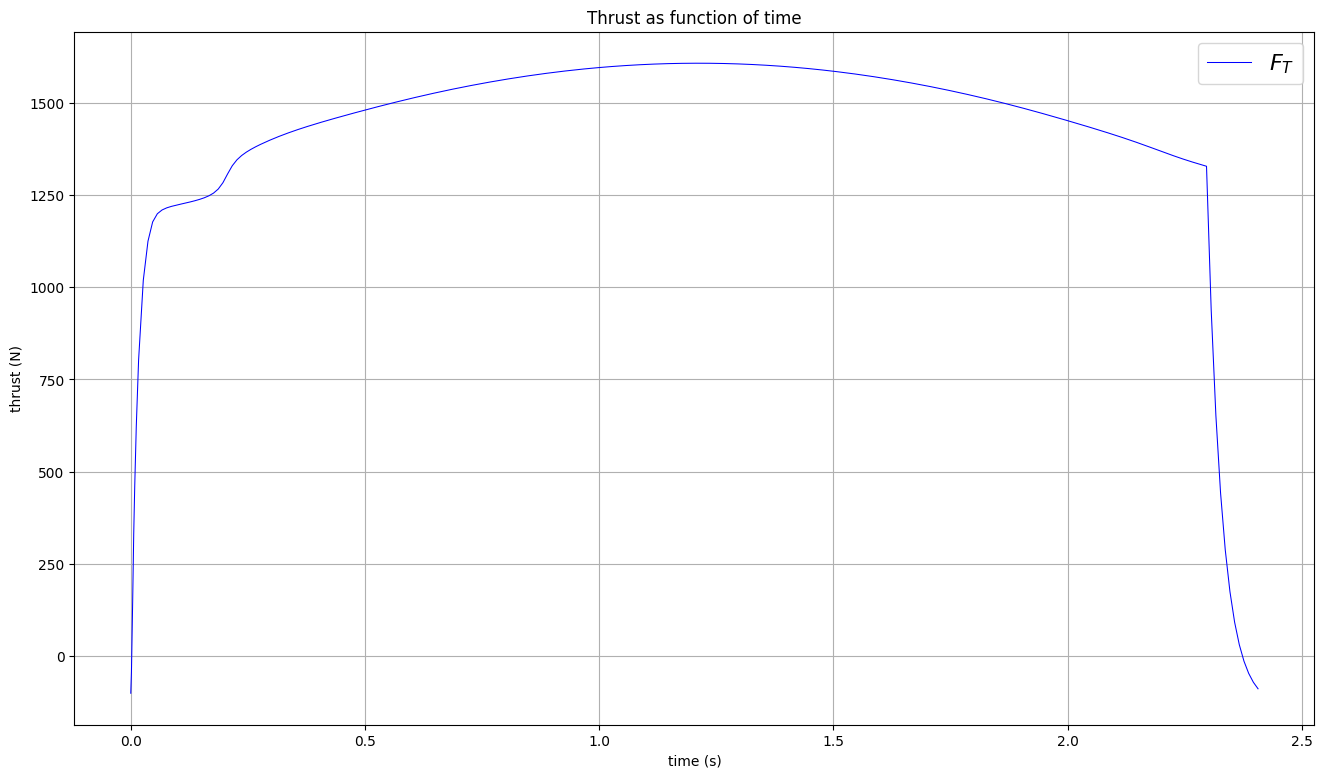

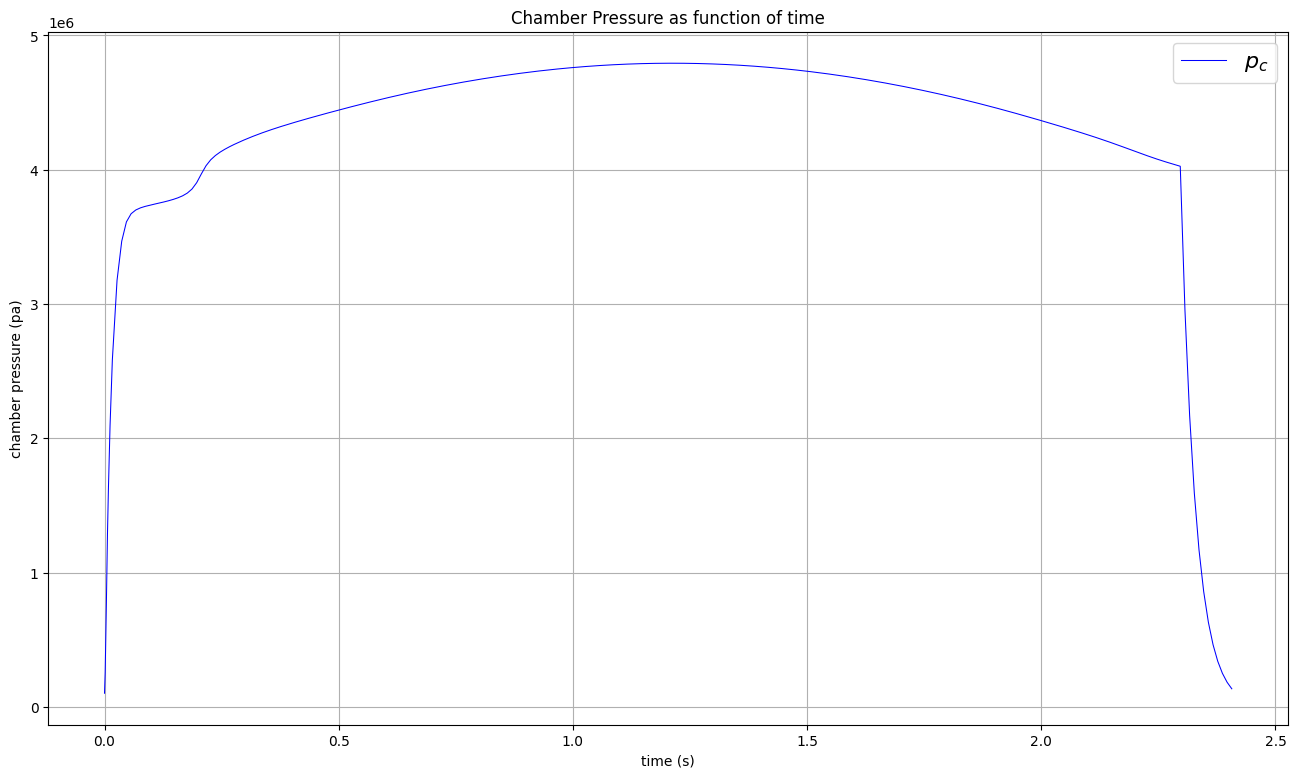

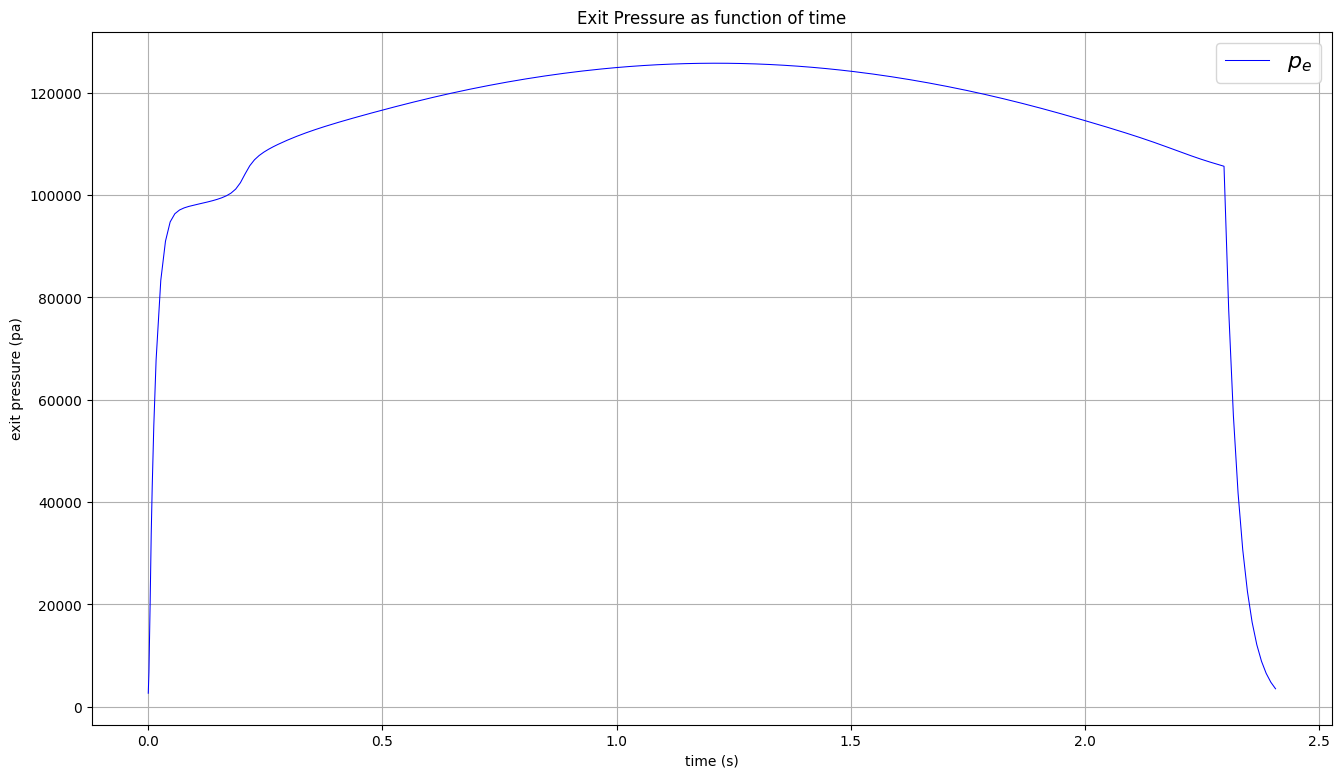

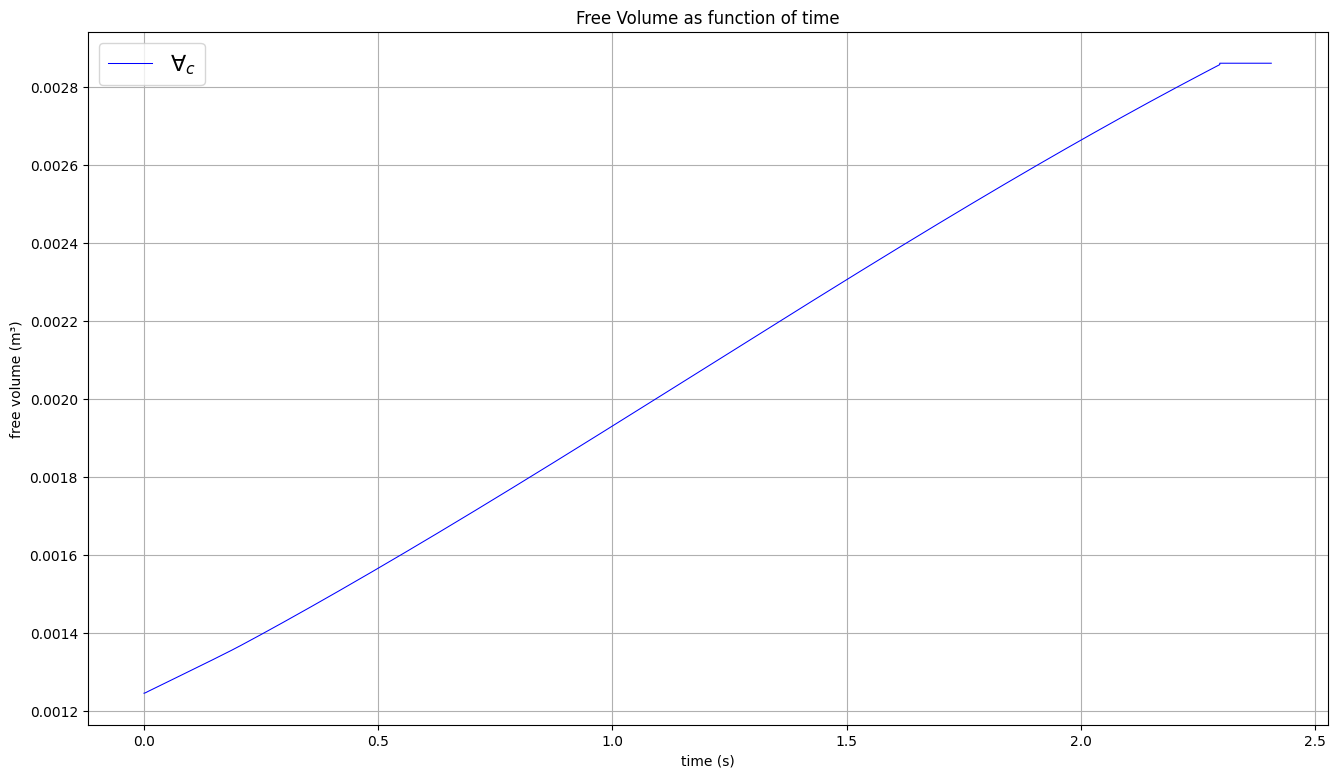

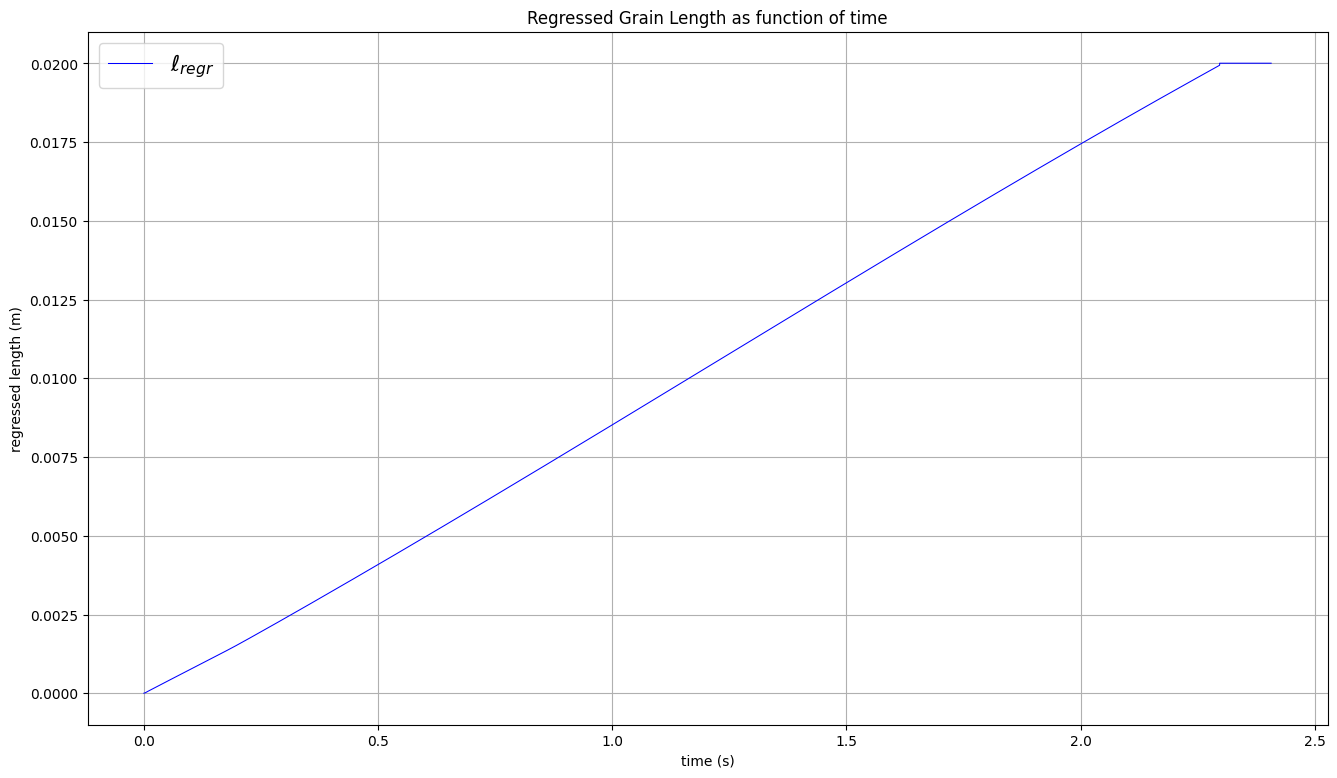

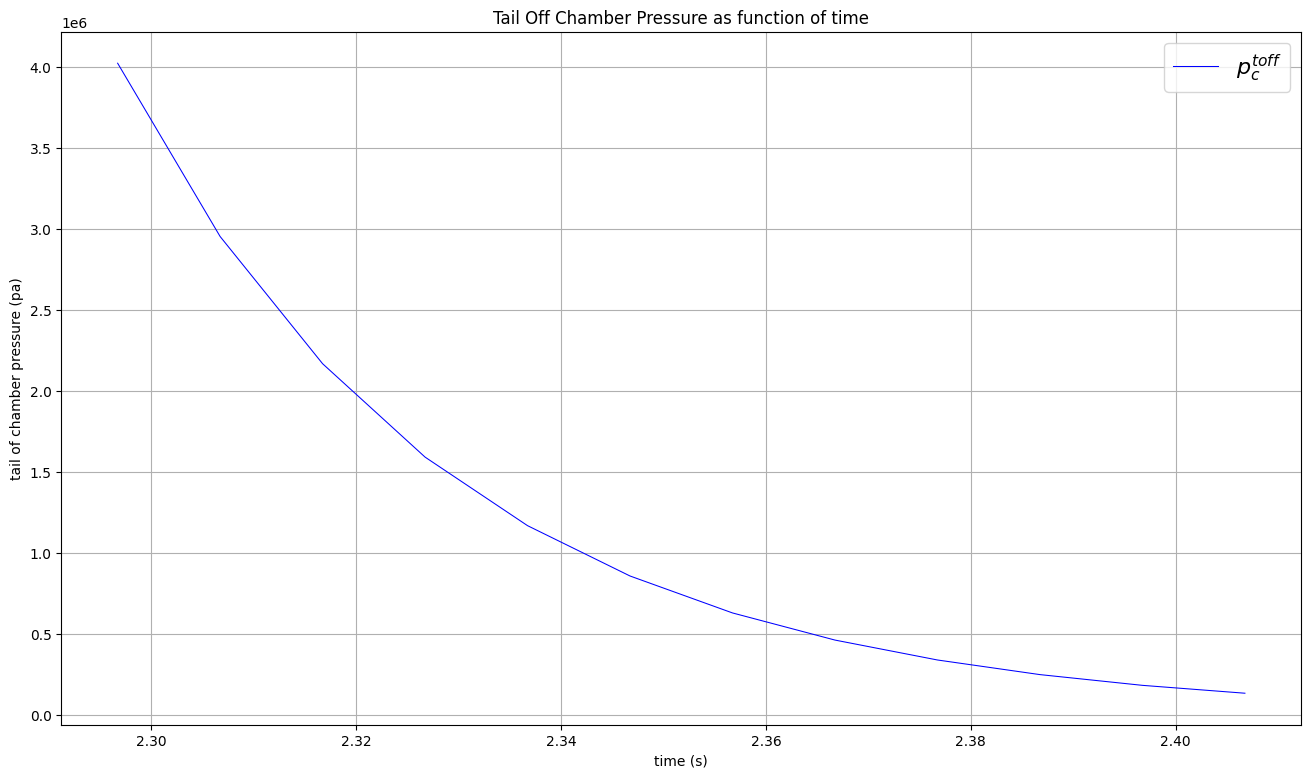

In [17]:
from solidpy.Burn import BurnExport

Simulation = BurnSimulation(Leviata, KNSB)
print(Simulation.evaluate_total_impulse(Simulation.thrust,Simulation.time))
print(Simulation.thrust)

SimulationData = BurnExport(Simulation)
SimulationData.max_thrust
SimulationData.all_info()
SimulationData.plotting()